# Third model: Training specialists
## Early stopping, Loading pre-trained model.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
from datetime import datetime
import os
import sys
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from nolearn.lasagne import BatchIterator
from scipy import signal
import tensorflow as tf

/Users/alex/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Loading data

Paths to datasets.

In [2]:
FTRAIN = '~/ML/kaggle/facial-keypoints-detection/data/training.csv'
FTEST = '~/ML/kaggle/facial-keypoints-detection/data/test.csv'
FLOOKUP = '~/ML/kaggle/facial-keypoints-detection/data/IdLookupTable.csv'

In [3]:
def load(test = False, cols = None):
    """
    Loads the dataset.
    
    Parameters
    ----------
    test     : optional, defaults to `False`
               Flag indicating if we need to load from `FTEST` (`True`) or FTRAIN (`False`)
    cols     : optional, defaults to `None`
               A list of columns you're interested in. If specified only returns these columns.
    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [4]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [5]:
num_channels = 1 # grayscale
image_size = 96

def load2d(test = False, cols = None):
    X, y = load(test = test, cols = cols)
    X = X.reshape(-1, image_size, image_size, num_channels)
    return X, y

## Parameters

In [6]:
# Predefined parameters
batch_size = 36
every_epoch_to_log = 5

data_augmentation = True
learning_rate_decay = True
momentum_increase = True
dropout = True
    
root_location = os.path.expanduser("~/ML/kaggle/facial-keypoints-detection/models/")

def model_name(spec_name):
    return "spec_" + spec_name

def model_path(spec_name):
    return root_location + "specialists/" + model_name(spec_name) + "/model.ckpt"

def train_history_path(spec_name):
    return root_location + "specialists/" + model_name(spec_name) + "/train_history"

def create_directory_for_specialist(spec_name):
    tf.gfile.MkDir(root_location)
    tf.gfile.MkDir(root_location + "specialists/")
    tf.gfile.MkDir(root_location + "specialists/" + model_name(spec_name) + "/")

## Specialists

In [55]:
SPECIALIST_SETTINGS = [
    dict(
        name = "eye_center",
        columns = (
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices = ((0, 2), (1, 3)),
        ),

    dict(
        name = "nose_tip",
        columns = (
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices = (),
        ),

    dict(
        name = "mouth_corner_top",
        columns = (
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices = ((0, 2), (1, 3)),
        ),

    dict(
        name = "mouth_bottom",
        columns = (
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices = (),
        ),

    dict(
        name = "eye_corner",
        columns = (
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices = ((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        name = "eyebrow",
        columns = (
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices = ((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

## Routines

This is our data augmentation routine. It randomly flips a defined portion of dataset horizontally.

In [8]:
# Generates a 2d array of size (side, side) with gaussian distribution peaking in the center and with `std` sigma. 
def gaussian2d(side, std):
    gaussian = np.matrix(signal.gaussian(side, std))
    return (gaussian.transpose() * gaussian).A

# Places 2d `matrix` array in another 2d array of shape `out_shape` with the offset specified in `offset`, top and left offsets respectively.
def place_matrix(matrix, out_shape, offset):
    # Pad the light matrix with zeros so that it is at least the size of the image (or bigger if it's shifted off the image boundaries)
    pad_top = max(0, offset[0])
    pad_bottom = max(0, out_shape[0] - matrix.shape[0] - offset[0])
    pad_left = max(0, offset[1])
    pad_right = max(0, out_shape[1] - matrix.shape[1] - offset[1])
    
    # Cut out the image-size piece of the resulting matrix, cutting either leading or trailing pieces, depending on the desired shift offset.
    y_start = max(0, -offset[0])
    y_end = max(out_shape[0], out_shape[0] - offset[0])
    x_start = max(0, -offset[1]) 
    x_end = max(out_shape[1], out_shape[1] - offset[1])
    return np.pad(matrix, ((pad_top, pad_bottom), (pad_left, pad_right)), mode = 'constant')[y_start:y_end, x_start:x_end]

class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def flip(self, Xb, yb, p = 0.5):
        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, int(bs * p), replace=False)
        Xb[indices] = Xb[indices, :, ::-1, :]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb
    
    def random_gaussian_light(self, Xb, yb, max_intensity = 0.5, size = 50):
        gaussian = gaussian2d(size, size / 6)
        for n in range(Xb.shape[0]):
            # Offset of the light spot. Somewhere in the bounding rect of facial keypoints, to make sure it adds some data variation.
            offset_y = np.random.randint(yb[n, 1::2].min() * 48 + 48 - size / 3, yb[n, 1::2].max() * 48 + 48 - 2 * size / 3) #y
            offset_x = np.random.randint(yb[n, ::2].min() * 48 + 48 - size / 3, yb[n, ::2].max() * 48 + 48 - 2 * size / 3) #x
            
            light_matrix = place_matrix(gaussian, (Xb.shape[1], Xb.shape[2]), (offset_y, offset_x))
            Xb[n] += light_matrix.reshape(light_matrix.shape + (1,)) * (max_intensity * np.random.random())
        return Xb, yb
    
    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)
        Xb, yb = self.flip(Xb, yb)
        Xb, yb = self.random_gaussian_light(Xb, yb)
        return Xb, yb

This is our early stopping routine.

In [9]:
class EarlyStopping(object):
    def __init__(self, saver, session, patience = 100):
        self.patience = patience
        self.saver = tf.train.Saver()
        self.session = session
        self.best_loss = np.inf
        self.best_loss_epoch = 0
        self.restore_path = None

    def __call__(self, loss, epoch):
        if loss < self.best_loss:
            self.best_loss = loss
            self.best_loss_epoch = epoch
            self.restore_path = self.saver.save(self.session, "early_stopping_checkpoint")
        elif self.best_loss_epoch + self.patience < epoch:
            print("Early stopping.\nBest monitored loss was {:.6f} at epoch {}.".format(
                self.best_loss, self.best_loss_epoch
            ))
            if self.restore_path != None:
                self.saver.restore(self.session, self.restore_path)
            else:
                print("ERROR: Failed to restore session")
            return True
        
        return False

Performs a single fully connected layer pass, e.g. returns `input * weights + bias`:

In [10]:
def fully_connected(input, size):
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer = tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

Routine for a single convolution layer pass.

In [11]:
def conv_relu(input, kernel_size, depth):
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer = tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides = [1, 1, 1, 1], padding = 'SAME')
    return tf.nn.relu(conv + biases)

Routine for a pooling layer.

In [12]:
def pool(input, size):
    return tf.nn.max_pool(
        input, 
        ksize = [1, size, size, 1], 
        strides = [1, size, size, 1], 
        padding = 'SAME'
    )

Routine that performs entire model pass, e.g. returns model prediction for given input with current model (3 convolution layers with 2 fully connected layers):

In [13]:
def model_pass(input, keypoints):
    # Convolutions
    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = 3, depth = 32) 
    with tf.variable_scope('pool1'): 
        pool1 = pool(conv1, size = 2)
        if dropout: pool1 = tf.nn.dropout(pool1, keep_prob = 0.9)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = 2, depth = 64)
    with tf.variable_scope('pool2'):
        pool2 = pool(conv2, size = 2)
        if dropout: pool2 = tf.nn.dropout(pool2, keep_prob = 0.8)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = 2, depth = 128)
    with tf.variable_scope('pool3'):
        pool3 = pool(conv3, size = 2)
        if dropout: pool3 = tf.nn.dropout(pool3, keep_prob = 0.7)
    
    # Fully connected
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    with tf.variable_scope('fc4'):
        fc4 = fully_connected(pool3, size = 1000)
        if dropout: fc4 = tf.nn.dropout(fc4, keep_prob = 0.5)
    with tf.variable_scope('fc5'):
        fc5 = fully_connected(fc4, size = 1000)
    with tf.variable_scope('out'):
        prediction = fully_connected(fc5, size = keypoints)
    return prediction

Calculates loss based on model predictions.

In [14]:
def calc_loss(predictions, labels):
    return np.mean(np.square(predictions - labels))

Calculates time since `start` and formats as a string.

In [15]:
def get_time_hhmmss(start):
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## Training

In [16]:
def get_predictions_in_batches(X, y, session, predictions, tf_x_batch, tf_y_batch):
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, y_batch in batch_iterator(X, y):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch, 
                tf_y_batch : y_batch
            }
        )
        p.extend(p_batch)
    return p

In [17]:
def train_specialist(spec_setting):
    # Initialising routines:
            
    # Load data and split into datasets
    X, y = load2d(cols = spec_setting['columns'])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)    
    
    # Work out some specialist settings and prepare the file paths
    spec_name = spec_setting['name']
    create_directory_for_specialist(spec_name)
    spec_var_scope = model_name(spec_name)
    initialising_model = "3con_2fc_b36_e1000_aug_lrdec_mominc_dr"

    # Calculate some of the training hyperparameters based on the specialist and available data
    max_epochs = int(1e7 / y.shape[0])
    num_keypoints = y.shape[1]
    
    # Note training time start
    spec_start = time.time()
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size, image_size, num_channels))
        tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))

        current_epoch = tf.Variable(0)  # count the number of epochs

        # Model parameters.
        learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps = max_epochs, decay_rate = 0.03) if learning_rate_decay else 0.01
        momentum = 0.9 + (0.99 - 0.9) * (current_epoch / max_epochs) if momentum_increase else 0.9

        # Training computation.
        with tf.variable_scope(spec_var_scope):
            predictions = model_pass(tf_x_batch, num_keypoints)

        loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))
        #loss = tf.reduce_mean(tf.square(predictions - tf_y_batch)) # + l2_lambda * (tf.nn.l2_loss(weightsInToHid) + tf.nn.l2_loss(weightsHidToOut))  

        # Optimizer.
        optimizer = tf.train.MomentumOptimizer(
            learning_rate = learning_rate, 
            momentum = momentum, 
            use_nesterov = True
        ).minimize(loss)
    
    # Initiate training
    with tf.Session(graph = graph) as session:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver()
        early_stopping = EarlyStopping(tf.train.Saver(), session)
        train_loss_history = np.zeros(max_epochs)
        valid_loss_history = np.zeros(max_epochs)
        
        print("======= RESTORING SESSION =======")
        variables_to_restore = [v for v in tf.all_variables() if "/out/" not in v.op.name]
        loader = tf.train.Saver({v.op.name.replace(spec_var_scope, initialising_model): v for v in variables_to_restore})
        load_path = root_location + initialising_model + "/model.ckpt"
        loader.restore(session, load_path)
        print(" Model loaded from: " + load_path)

        print("======= TRAINING: " + spec_name.replace("_", " ").upper() + " on " + str(y.shape[0]) + " EXAMPLES ========")
        for epoch in range(max_epochs):
            current_epoch = epoch
            # Train on whole randomised dataset in batches
            batch_iterator = FlipBatchIterator(batch_size = batch_size, shuffle = True) if data_augmentation else BatchIterator(batch_size = batch_size, shuffle = True)
            batch_iterator.flip_indices = spec_setting['flip_indices']
            for x_batch, y_batch in batch_iterator(x_train, y_train):
                session.run([optimizer], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch
                    }
                )

            # Get validation data predictions and log validation loss:
            valid_loss = calc_loss(
                get_predictions_in_batches(x_valid, y_valid, session, predictions, tf_x_batch, tf_y_batch), 
                y_valid
            )
            valid_loss_history[epoch] = valid_loss
            
            # If another significant epoch ended, we log our losses.
            if (epoch % every_epoch_to_log == 0):
                # Get training data predictions and log training loss:
                train_loss = calc_loss(
                    get_predictions_in_batches(x_train, y_train, session, predictions, tf_x_batch, tf_y_batch), 
                    y_train
                )
                train_loss_history[epoch] = train_loss

                if (epoch % 100 == 0):
                    print("--------- EPOCH %4d/%d ---------" % (epoch, max_epochs))
                    print("     Train loss: %.8f" % (train_loss))
                    print("Validation loss: %.8f" % (valid_loss))
                    print("           Time: " + get_time_hhmmss(spec_start))
            
            if early_stopping(valid_loss, epoch): break
            
        # Evaluate on test dataset.
        test_loss = calc_loss(
            get_predictions_in_batches(x_test, y_test, session, predictions, tf_x_batch, tf_y_batch), 
            y_test
        )
        print("=========== " + spec_name.replace("_", " ").upper() + ": ============")
        print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
        print(" Total time: " + get_time_hhmmss(spec_start))

        # Save model weights for future use.
        save_path = saver.save(session, model_path(spec_name))
        print("Model file: " + save_path)
        np.savez(train_history_path(spec_name), train_loss_history = train_loss_history, valid_loss_history = valid_loss_history)
        print("Train history file: " + train_history_path(spec_name))        
        print("\n")

In [18]:
start = time.time()

for spec_setting in SPECIALIST_SETTINGS:
    train_specialist(spec_setting)
    
print("====== ALL SPECIALISTS TRAINED =======")
print(" Total time: " + get_time_hhmmss(start))

======= RESTORING SESSION =======
 Model loaded from: /home/ubuntu/ML/kaggle/facial-keypoints-detection/models/3con_2fc_b36_e1000_aug_lrdec_mominc_dr/model.ckpt
======= TRAINING: NOSE TIP on 7049 EXAMPLES ========
--------- EPOCH    0/1418 ---------
     Train loss: 0.01086836
Validation loss: 0.01065206
           Time: 00:00:22
--------- EPOCH  100/1418 ---------
     Train loss: 0.00450801
Validation loss: 0.00564750
           Time: 00:22:14
--------- EPOCH  200/1418 ---------
     Train loss: 0.00348404
Validation loss: 0.00491733
           Time: 00:43:35
--------- EPOCH  300/1418 ---------
     Train loss: 0.00331002
Validation loss: 0.00514375
           Time: 01:04:58
--------- EPOCH  400/1418 ---------
     Train loss: 0.00290428
Validation loss: 0.00504640
           Time: 01:26:20
Early stopping.
Best monitored loss was 0.004614 at epoch 375.
=========== NOSE TIP: ============
 Test score: 3.413 (loss = 0.00505720)
 Total time: 01:42:31
Model file: /home/ubuntu/ML/kaggle/fa

## Evaluation

In [25]:
# Plots history of learning curves for a specific model. You may want to call `pyplot.show()` afterwards.
def plot_learning_curves(spec_name, color):
    model_history = np.load(train_history_path(spec_name) + ".npz")
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    pyplot.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], color + "--", linewidth=2, label = spec_name.replace("_", " ").title())
    pyplot.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], color + "-", linewidth=2)
    return epochs

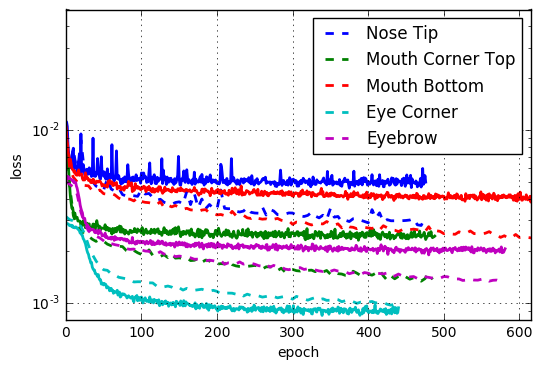

In [26]:
max_model_epochs = 0
colors = ["b", "g", "r", "c", "m", "y", "k", "w"]
for spec_setting in SPECIALIST_SETTINGS:
    spec_epochs = plot_learning_curves(spec_setting['name'], colors[SPECIALIST_SETTINGS.index(spec_setting) % len(colors)])
    if spec_epochs > max_model_epochs:
        max_model_epochs = spec_epochs

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.0008, 0.05)
pyplot.xlim(0, 615)
pyplot.yscale("log")
pyplot.show()

Now, let's take a look at the data and predictions. 

Load training data, restore saved model parameters and get predictions:

In [4]:
X, _ = load(test = True)

with graph.as_default():
    tf_x = tf.constant(X)

    with tf.variable_scope(model_variable_scope, reuse = True):
        tf_p = model_pass(tf_x)  
        
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    load_path = saver.restore(session, model_path(SPECIALIST_SETTINGS[0].name))
    p = tf_p.eval()

NameError: name 'load' is not defined

## Submission

In [56]:
def evaluate_specialist(X, spec_name, num_keypoints):
    # Work out some specialist settings and prepare the file paths
    spec_var_scope = model_name(spec_name)
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size, image_size, num_channels))
        with tf.variable_scope(spec_var_scope, reuse = False):
            tf_p_batch = model_pass(tf_x_batch, num_keypoints) 
    
    with tf.Session(graph = graph) as session:
        saver = tf.train.Saver()
        saver.restore(session, model_path(spec_name))        
        p = []
        batch_iterator = BatchIterator(batch_size = 128)
        for x_batch, _ in batch_iterator(X):
            [p_batch] = session.run([tf_p_batch], feed_dict = {
                    tf_x_batch : x_batch 
                }
            )
            p.extend(p_batch)
        return p

In [59]:
def generate_submission():
    X = load2d(test=True)[0]
    y_pred = np.empty((X.shape[0], 0))

    columns = ()
    for spec_setting in SPECIALIST_SETTINGS:
        p = evaluate_specialist(X, spec_setting['name'], len(spec_setting['columns']))
        y_pred = np.hstack([y_pred, p])
        columns += spec_setting['columns']

    y_pred2 = y_pred * 48 + 48
    y_pred2 = y_pred2.clip(0, 96)
    df = DataFrame(y_pred2, columns=columns)

    lookup_table = read_csv(os.path.expanduser(FLOOKUP))
    values = []

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            df.ix[row.ImageId - 1][row.FeatureName],
            ))

    now_str = datetime.now().isoformat().replace(':', '-')
    submission = DataFrame(values, columns=('RowId', 'Location'))
    filename = root_location + 'specialists/submission-{}.csv'.format(now_str)
    submission.to_csv(filename, index=False)
    print("Wrote {}".format(filename))

In [60]:
generate_submission()

Wrote /home/ubuntu/ML/kaggle/facial-keypoints-detection/models/specialists/submission-2016-11-18T16-30-17.183387.csv
